<a href="https://colab.research.google.com/github/gennettezimmer/ESG_Analytics/blob/master/ESG_Analytics_for_Food_Related_Sectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages and Mount Drives

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statistics as st
import matplotlib.gridspec as gridspec

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from scipy.stats import shapiro, pearsonr, ttest_ind, f_oneway

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ESG_DATA = '/content/drive/MyDrive/Portfolio_Projects/MSCI_esg_2022.xlsx'

In [4]:
ESG = pd.read_excel(ESG_DATA, sheet_name="MSCI_esg")
ESG['Rating_list'] = ESG['Rating_list'].apply(str)
ESG.drop(['Ticker'], axis=1, inplace=True)
CC = pd.read_excel(ESG_DATA, sheet_name="country_codes")
CC.drop(['CT_3','CT_Code','ISO_Entry_3166-2','intermediate_region','region_code','sub_region_code','intermediate_region_code'], axis=1, inplace=True)
CC.rename(columns = {'name':'Country', 'region':'Region', 'sub_region':'Sub_Region'}, inplace = True)

In [5]:
GDP = pd.read_excel(ESG_DATA, sheet_name="GDP")
GDP.drop(['Country'], axis=1, inplace=True)
GDP['IMF_GDP_Year'] = GDP['IMF_GDP_Year'].apply(str)
GDP['UN_GDP_Year'] = GDP['UN_GDP_Year'].apply(str)
GDP['World_Bank_GDP_Year'] = GDP['World_Bank_GDP_Year'].apply(str)
GDP['IMF_GDP_Year'] = GDP['IMF_GDP_Year'].str[:-2]
GDP['UN_GDP_Year'] = GDP['UN_GDP_Year'].str[:-2]
GDP['World_Bank_GDP_Year'] = GDP['World_Bank_GDP_Year'].str[:-2]

# Exploratory Data Analysis (EDA) - Overall

In [85]:
#Look up ESG info
ESG.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15644 entries, 0 to 15645
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company_Name         15644 non-null  object 
 1   CT_2                 15644 non-null  object 
 2   Sector               15644 non-null  object 
 3   Subsector            15644 non-null  object 
 4   Overall_ESG_RATING   15644 non-null  object 
 5   Rating_list          15644 non-null  object 
 6   Overall_ESG_SCORE    15644 non-null  float64
 7   Environmental_SCORE  15644 non-null  float64
 8   Social_SCORE         15644 non-null  float64
 9   Governance_SCORE     15644 non-null  float64
dtypes: float64(4), object(6)
memory usage: 1.3+ MB


In [86]:
# Fill in null subsectors with sector
ESG['Subsector'] = np.where(ESG['Subsector'].isnull(), ESG['Sector'], ESG['Subsector'])

In [87]:
# Find null CT_2
ESG[ESG['CT_2'].isnull()]

,Company_Name,CT_2,Sector,Subsector,Overall_ESG_RATING,Rating_list,Overall_ESG_SCORE,Environmental_SCORE,Social_SCORE,Governance_SCORE


In [88]:
# Remove both rows for banks in Namibia
ESG = ESG.loc[ESG['Company_Name'] != "First National Bank of Namibia Limited"]
ESG = ESG.loc[ESG['Company_Name'] != "Standard Bank Namibia Limited"]

In [89]:
# Confirm ESG null rows are deleted
ESG.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15644 entries, 0 to 15645
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company_Name         15644 non-null  object 
 1   CT_2                 15644 non-null  object 
 2   Sector               15644 non-null  object 
 3   Subsector            15644 non-null  object 
 4   Overall_ESG_RATING   15644 non-null  object 
 5   Rating_list          15644 non-null  object 
 6   Overall_ESG_SCORE    15644 non-null  float64
 7   Environmental_SCORE  15644 non-null  float64
 8   Social_SCORE         15644 non-null  float64
 9   Governance_SCORE     15644 non-null  float64
dtypes: float64(4), object(6)
memory usage: 1.3+ MB


In [90]:
# Get info for country code
CC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 0 to 248
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     247 non-null    object 
 1   CT_2        247 non-null    object 
 2   Region      247 non-null    object 
 3   Sub_Region  247 non-null    object 
 4   EU          247 non-null    float64
 5   G20         247 non-null    float64
 6   OPEC        247 non-null    float64
 7   WTO         247 non-null    float64
 8   PA          247 non-null    float64
 9   UN          247 non-null    float64
 10  NATO        247 non-null    float64
dtypes: float64(7), object(4)
memory usage: 23.2+ KB


In [91]:
# Fill NA's for affiliation groups
CC['EU'] = CC['EU'].fillna(0)
CC['G20'] = CC['G20'].fillna(0)
CC['OPEC'] = CC['OPEC'].fillna(0)
CC['WTO'] = CC['WTO'].fillna(0)
CC['PA'] = CC['PA'].fillna(0)
CC['UN'] = CC['UN'].fillna(0)
CC['NATO'] = CC['NATO'].fillna(0)

In [92]:
# Locate null CT value
CC[CC['CT_2'].isnull()]

,Country,CT_2,Region,Sub_Region,EU,G20,OPEC,WTO,PA,UN,NATO


In [93]:
# Remove null row for Namibia
CC = CC.loc[CC['Country'] != "Namibia"]

In [94]:
# Locate null region value
CC[CC['Region'].isnull()]

,Country,CT_2,Region,Sub_Region,EU,G20,OPEC,WTO,PA,UN,NATO


In [95]:
# Locate null sub-region value
CC[CC['Sub_Region'].isnull()]

,Country,CT_2,Region,Sub_Region,EU,G20,OPEC,WTO,PA,UN,NATO


In [96]:
# Remove null row for Antarctica
CC = CC.loc[CC['Country'] != "Antarctica"]

In [97]:
# Review info for country code
CC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 0 to 248
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     247 non-null    object 
 1   CT_2        247 non-null    object 
 2   Region      247 non-null    object 
 3   Sub_Region  247 non-null    object 
 4   EU          247 non-null    float64
 5   G20         247 non-null    float64
 6   OPEC        247 non-null    float64
 7   WTO         247 non-null    float64
 8   PA          247 non-null    float64
 9   UN          247 non-null    float64
 10  NATO        247 non-null    float64
dtypes: float64(7), object(4)
memory usage: 23.2+ KB


In [98]:
ESG.head(2)

,Company_Name,CT_2,Sector,Subsector,Overall_ESG_RATING,Rating_list,Overall_ESG_SCORE,Environmental_SCORE,Social_SCORE,Governance_SCORE
0,0921706 BC LTD,CA,Telecommunication Services,Wireless Telecommunication Services,A,3,6.6,10.0,7.4,2.7
1,"1000 AUAHI, LLC",US,Real Estate Development & Diversified Activities,Real Estate Development,A,3,6.8,6.1,4.1,6.9


In [99]:
CC.head(2)

,Country,CT_2,Region,Sub_Region,EU,G20,OPEC,WTO,PA,UN,NATO
0,Afghanistan,AF,Asia,Southern Asia,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,Åland Islands,AX,Europe,Northern Europe,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# Merge ESG data with Country Code information
ESG_CC = pd.merge(ESG, CC, on='CT_2')

In [101]:
# Reorganize data
cats = list(ESG_CC.select_dtypes(include=['object']).columns)
nums = list(ESG_CC.select_dtypes(exclude=['object']).columns)

In [102]:
print(f'categorical variables:  {cats}')

categorical variables:  ['Company_Name', 'CT_2', 'Sector', 'Subsector', 'Overall_ESG_RATING', 'Rating_list', 'Country', 'Region', 'Sub_Region']


In [103]:
print(f'numerical variables:  {nums}')

numerical variables:  ['Overall_ESG_SCORE', 'Environmental_SCORE', 'Social_SCORE', 'Governance_SCORE', 'EU', 'G20', 'OPEC', 'WTO', 'PA', 'UN', 'NATO']


In [104]:
ESG_CC = pd.concat((ESG_CC[cats], ESG_CC[nums]), axis=1)

In [105]:
ESG_CC = ESG_CC[['Country', 'Region', 'CT_2', 'Sub_Region','Company_Name', 'Sector', 'Subsector', 'Overall_ESG_RATING', 'Rating_list', 'Overall_ESG_SCORE', 'Environmental_SCORE', 'Social_SCORE', 'Governance_SCORE', 'EU', 'G20', 'OPEC', 'WTO', 'PA', 'UN', 'NATO']]

In [106]:
ESG_CC.head(2)

,Country,Region,CT_2,Sub_Region,Company_Name,Sector,Subsector,Overall_ESG_RATING,Rating_list,Overall_ESG_SCORE,Environmental_SCORE,Social_SCORE,Governance_SCORE,EU,G20,OPEC,WTO,PA,UN,NATO
0,Canada,Americas,CA,Northern America,0921706 BC LTD,Telecommunication Services,Wireless Telecommunication Services,A,3,6.6,10.0,7.4,2.7,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1,Canada,Americas,CA,Northern America,ALIMENTATION COUCHE-TARD INC,Retail - Food & Staples,Food Retail,A,3,6.5,4.7,4.7,5.6,0.0,1.0,0.0,1.0,1.0,1.0,1.0


In [107]:
ESG_CC.shape

(15644, 20)

In [108]:
# Combined ESG_CC table info
ESG_CC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15644 entries, 0 to 15643
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              15644 non-null  object 
 1   Region               15644 non-null  object 
 2   CT_2                 15644 non-null  object 
 3   Sub_Region           15644 non-null  object 
 4   Company_Name         15644 non-null  object 
 5   Sector               15644 non-null  object 
 6   Subsector            15644 non-null  object 
 7   Overall_ESG_RATING   15644 non-null  object 
 8   Rating_list          15644 non-null  object 
 9   Overall_ESG_SCORE    15644 non-null  float64
 10  Environmental_SCORE  15644 non-null  float64
 11  Social_SCORE         15644 non-null  float64
 12  Governance_SCORE     15644 non-null  float64
 13  EU                   15644 non-null  float64
 14  G20                  15644 non-null  float64
 15  OPEC                 15644 non-null 

In [109]:
# Count of unique values
ESG_CC.nunique(axis=0)

Country                  108
Region                     5
CT_2                     108
Sub_Region                15
Company_Name           15558
Sector                    69
Subsector                192
Overall_ESG_RATING         7
Rating_list                7
Overall_ESG_SCORE        117
Environmental_SCORE      101
Social_SCORE             101
Governance_SCORE          88
EU                         2
G20                        2
OPEC                       2
WTO                        2
PA                         2
UN                         2
NATO                       2
dtype: int64

In [110]:
# Merge ESG with GDP
ESG_GDP = pd.merge(ESG_CC, GDP, on='CT_2')
ESG_GDP.drop(['EU','G20','OPEC','WTO','PA','UN','NATO'], axis=1, inplace=True)
ESG_GDP.head(3)

,Country,Region,CT_2,Sub_Region,Company_Name,Sector,Subsector,Overall_ESG_RATING,Rating_list,Overall_ESG_SCORE,Environmental_SCORE,Social_SCORE,Governance_SCORE,IMF_GDP_Estimate,IMF_GDP_Year,UN_GDP_Estimate,UN_GDP_Year,World_Bank_GDP_Estimate,World_Bank_GDP_Year
0,Canada,Americas,CA,Northern America,0921706 BC LTD,Telecommunication Services,Wireless Telecommunication Services,A,3,6.6,10.0,7.4,2.7,2221218.0,2022,1644037.0,2020,1643408.0,2020
1,Canada,Americas,CA,Northern America,ALIMENTATION COUCHE-TARD INC,Retail - Food & Staples,Food Retail,A,3,6.5,4.7,4.7,5.6,2221218.0,2022,1644037.0,2020,1643408.0,2020
2,Canada,Americas,CA,Northern America,ATCO LTD,Utilities,Multi-Utilities,A,3,6.1,7.1,6.2,3.8,2221218.0,2022,1644037.0,2020,1643408.0,2020



# EDA for Sector focused research - Food and Beverage
'Beverages', 'Food Products', 'Retail - Food & Staples', 'Restaurants'

In [111]:
ESG.Sector.unique()

array(['Telecommunication Services',
       'Real Estate Development & Diversified Activities',
       'Health Care Providers & Services', 'Software & Services',
       'Biotechnology', 'Real Estate Management & Services',
       'Building Products', 'Diversified Consumer Services',
       'Electronic Equipment, Instruments & Components',
       'Property & Casualty Insurance', 'Utilities',
       'Health Care Equipment & Supplies',
       'Commercial Services & Supplies', 'Banks',
       'Transportation Infrastructure',
       'Oil & Gas Refining, Marketing, Transportation & Storage',
       'Beverages', 'Retail - Consumer Discretionary', 'Casinos & Gaming',
       'Hotels & Travel', 'Industrial Machinery',
       'Construction & Engineering', 'Food Products',
       'Interactive Media & Services',
       'Technology Hardware, Storage & Peripherals',
       'Diversified Financials',
       'Semiconductors & Semiconductor Equipment', 'Consumer Finance',
       'Trading Companies & Dist

In [112]:
ESG_All = ESG_CC[['Country', 'Region', 'CT_2', 'Sub_Region','Company_Name', 'Sector', 'Overall_ESG_RATING', 'Rating_list', 'Overall_ESG_SCORE', 'Environmental_SCORE', 'Social_SCORE', 'Governance_SCORE']]
ESG_Food = ESG_All.loc[ESG_All['Sector'].isin(['Beverages', 'Food Products', 'Retail - Food & Staples', 'Restaurants'])]
ESG_Food_USA = ESG_Food.loc[ESG_Food['CT_2'] == 'US']
ESG_Food_OTH = ESG_Food.loc[ESG_Food['CT_2'] != 'US']
ESG_All = ESG_All.sort_values('Rating_list', ascending=True)
ESG_Food = ESG_Food.sort_values('Rating_list', ascending=True)
ESG_Food_USA = ESG_Food_USA.sort_values('Rating_list', ascending=True)
ESG_Food_OTH = ESG_Food_OTH.sort_values('Rating_list', ascending=True)

In [113]:
ESG_All.info()
#ESG_Food.info()
#ESG_Food_USA.info()
#ESG_Food_OTH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15644 entries, 9642 to 13757
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              15644 non-null  object 
 1   Region               15644 non-null  object 
 2   CT_2                 15644 non-null  object 
 3   Sub_Region           15644 non-null  object 
 4   Company_Name         15644 non-null  object 
 5   Sector               15644 non-null  object 
 6   Overall_ESG_RATING   15644 non-null  object 
 7   Rating_list          15644 non-null  object 
 8   Overall_ESG_SCORE    15644 non-null  float64
 9   Environmental_SCORE  15644 non-null  float64
 10  Social_SCORE         15644 non-null  float64
 11  Governance_SCORE     15644 non-null  float64
dtypes: float64(4), object(8)
memory usage: 1.6+ MB


In [114]:
# Function to return description, median and modes for all of the scores
def describe(df):
  de = df[['Overall_ESG_SCORE','Environmental_SCORE','Social_SCORE','Governance_SCORE']].describe().transpose()
  me = df[['Overall_ESG_SCORE','Environmental_SCORE','Social_SCORE','Governance_SCORE']].median()
  mo = df[['Overall_ESG_SCORE','Environmental_SCORE','Social_SCORE','Governance_SCORE']].mode().transpose()
  return print('Score Description\n',de, '\n\nScore Median\n',me, '\n\nScore Mode\n',mo)

In [115]:
describe(ESG_All)

Score Description
                        count      mean       std  min  25%  50%  75%   max
Overall_ESG_SCORE    15644.0  5.143688  2.333357  0.0  3.4  5.3  7.0  10.0
Environmental_SCORE  15644.0  5.314977  2.407475  0.0  3.5  5.2  7.0  10.0
Social_SCORE         15644.0  4.617483  1.591274  0.0  3.6  4.6  5.6  10.0
Governance_SCORE     15644.0  4.789772  1.593041  0.0  3.8  5.0  6.0   9.8 

Score Median
 Overall_ESG_SCORE      5.3
Environmental_SCORE    5.2
Social_SCORE           4.6
Governance_SCORE       5.0
dtype: float64 

Score Mode
                         0
Overall_ESG_SCORE     7.0
Environmental_SCORE  10.0
Social_SCORE          4.6
Governance_SCORE      5.3


In [116]:
describe(ESG_Food)

Score Description
                      count      mean       std  min  25%  50%  75%   max
Overall_ESG_SCORE    745.0  5.057450  2.322210  0.0  3.2  5.1  7.0  10.0
Environmental_SCORE  745.0  3.500268  1.804333  0.0  2.0  3.3  4.6  10.0
Social_SCORE         745.0  4.936779  1.157997  1.1  4.2  5.0  5.7   8.5
Governance_SCORE     745.0  4.788054  1.497078  0.0  3.7  4.8  5.9   8.3 

Score Median
 Overall_ESG_SCORE      5.1
Environmental_SCORE    3.3
Social_SCORE           5.0
Governance_SCORE       4.8
dtype: float64 

Score Mode
                        0    1
Overall_ESG_SCORE    5.7  NaN
Environmental_SCORE  2.0  NaN
Social_SCORE         5.4  NaN
Governance_SCORE     3.8  4.5


In [117]:
describe(ESG_Food_USA)

Score Description
                      count      mean       std  min   25%  50%   75%   max
Overall_ESG_SCORE    167.0  5.355689  2.214019  0.0  3.85  5.1  7.20  10.0
Environmental_SCORE  167.0  3.754491  2.122703  0.0  2.00  3.4  5.35  10.0
Social_SCORE         167.0  4.715569  1.131742  2.7  4.00  4.5  5.30   8.5
Governance_SCORE     167.0  5.291617  1.127339  1.9  4.50  5.3  6.20   7.6 

Score Median
 Overall_ESG_SCORE      5.1
Environmental_SCORE    3.4
Social_SCORE           4.5
Governance_SCORE       5.3
dtype: float64 

Score Mode
                        0
Overall_ESG_SCORE    5.7
Environmental_SCORE  4.1
Social_SCORE         5.0
Governance_SCORE     6.2


In [118]:
describe(ESG_Food_OTH)

Score Description
                      count      mean       std  min    25%  50%  75%   max
Overall_ESG_SCORE    578.0  4.971280  2.347343  0.0  3.000  5.1  7.0  10.0
Environmental_SCORE  578.0  3.426817  1.696308  0.0  2.025  3.3  4.4   9.6
Social_SCORE         578.0  5.000692  1.158586  1.1  4.300  5.1  5.8   8.5
Governance_SCORE     578.0  4.642561  1.558747  0.0  3.600  4.5  5.7   8.3 

Score Median
 Overall_ESG_SCORE      5.1
Environmental_SCORE    3.3
Social_SCORE           5.1
Governance_SCORE       4.5
dtype: float64 

Score Mode
                        0
Overall_ESG_SCORE    7.0
Environmental_SCORE  2.0
Social_SCORE         5.4
Governance_SCORE     3.8


# Hypothesis testing

In [119]:

data = ESG_Food['Overall_ESG_SCORE']
data1 = ESG_Food['Environmental_SCORE']
data2 = ESG_Food['Social_SCORE']
data3 = ESG_Food['Governance_SCORE']

In [120]:
# Shapiro-Wilk Normality Test
# H0 - ESG Food Sector Overall ESG Score data has a Gaussian distribution
# H1 - ESG Food Sector Overall ESG Score data is not a Gaussian distribution

stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.982, p=0.000
Probably not Gaussian


In [121]:
# Pearson's Correlation test
# H0 - ESG Food Sector data Overall Score is independent of the Environmental Score
# H1 - ESG Food Sector data Overall Score has a dependency on the Environmenal Score

stat, p = pearsonr(data, data1)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=0.637, p=0.000
Probably dependent


In [122]:
# Student's t-test 
# H0 - ESG Food Sector data Overall Score is independent of the Environmental Score
# H1 - ESG Food Sector data Overall Score has a dependency on the Environmenal Score

stat, p = ttest_ind(data, data3)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=2.661, p=0.008
Probably different distributions


In [123]:
# ANOVA test

stat, p = f_oneway(data1, data2, data3)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=203.964, p=0.000
Probably different distributions



# Histogram Comparison of Scores for Food related sectors

In [124]:
# Compare four countries/member organziations
def create_histogram_4(plot1_f,DF_1,grp_1,DF_2,grp_2,DF_3,grp_3,DF_4,grp_4):
    with plt.style.context(("seaborn","ggplot")):
        fig = plt.figure(constrained_layout=True, figsize=(10,8))
        specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) ## Declaring 2x2 figure.

        ax1 = fig.add_subplot(specs[0, 0]) ## First Row First Column
        ax1.set_xlim([0, 10])
        ax2 = fig.add_subplot(specs[0, 1]) ## First Row Second Column
        ax2.set_xlim([0, 10])
        ax3 = fig.add_subplot(specs[1, 0]) ## Second Row First Column
        ax3.set_xlim([0, 10])
        ax4 = fig.add_subplot(specs[1, 1]) ## Second Row Second Colums
        ax4.set_xlim([0, 10])

        ## First Graph - Histogram
        ax1.hist(DF_1[plot1_f], color="tab:red", )
        ax1.set_ylabel(plot1_f)
        ax1.set_title(grp_1)

        ## Second Graph - Histogram
        ax2.hist(DF_2[plot1_f], color="tab:green", )
        ax2.set_ylabel(plot1_f)
        ax2.set_title(grp_2)

        ## Third Graph - Histogram
        ax3.hist(DF_3[plot1_f], color="tab:blue", )
        ax3.set_ylabel(plot1_f)
        ax3.set_title(grp_3)

        ## Fourth Graph - Histogram
        ax4.hist(DF_4[plot1_f], color="tab:orange", )
        ax4.set_ylabel(plot1_f)
        ax4.set_title(grp_4)

        plt.close(fig)
        return fig

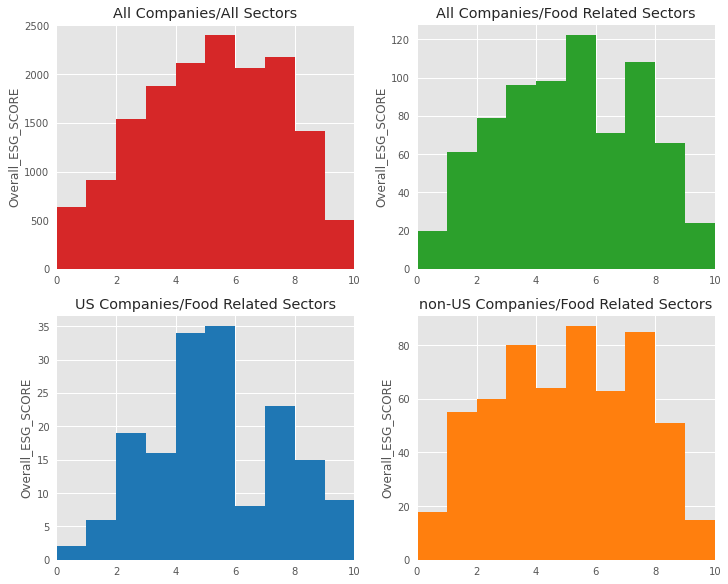

In [125]:
create_histogram_4('Overall_ESG_SCORE',ESG_All,'All Companies/All Sectors',ESG_Food,'All Companies/Food Related Sectors',ESG_Food_USA,'US Companies/Food Related Sectors',ESG_Food_OTH,'non-US Companies/Food Related Sectors')

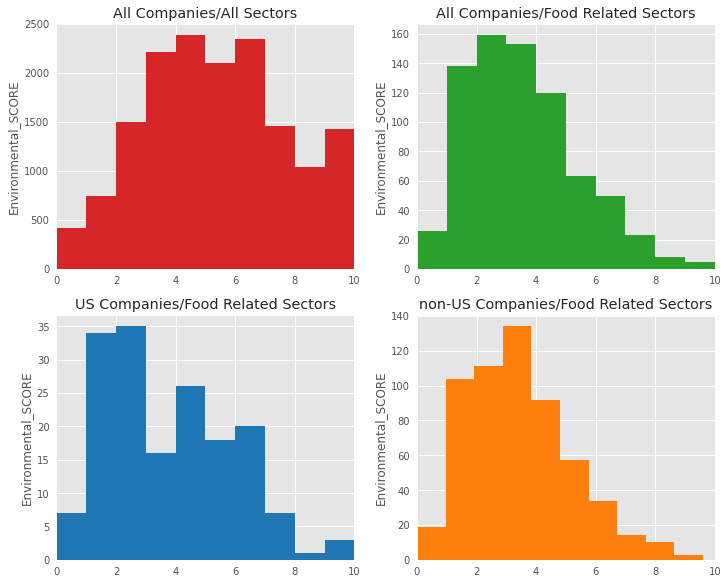

In [126]:
create_histogram_4('Environmental_SCORE',ESG_All,'All Companies/All Sectors',ESG_Food,'All Companies/Food Related Sectors',ESG_Food_USA,'US Companies/Food Related Sectors',ESG_Food_OTH,'non-US Companies/Food Related Sectors')

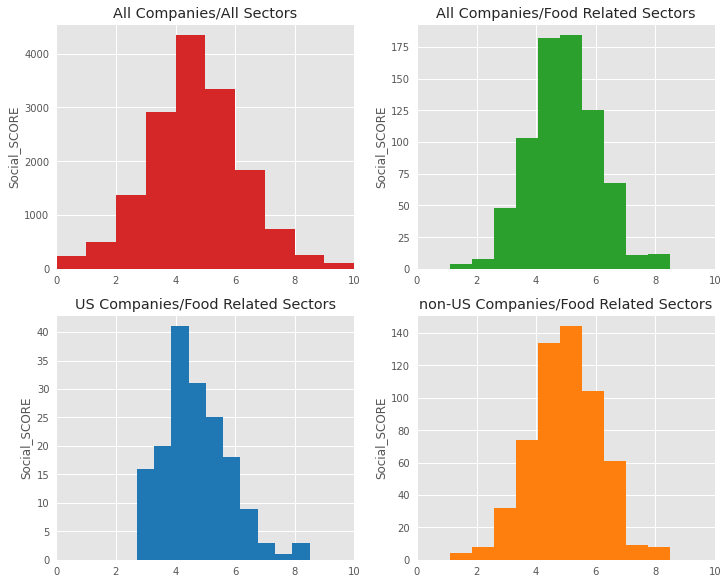

In [127]:
create_histogram_4('Social_SCORE',ESG_All,'All Companies/All Sectors',ESG_Food,'All Companies/Food Related Sectors',ESG_Food_USA,'US Companies/Food Related Sectors',ESG_Food_OTH,'non-US Companies/Food Related Sectors')

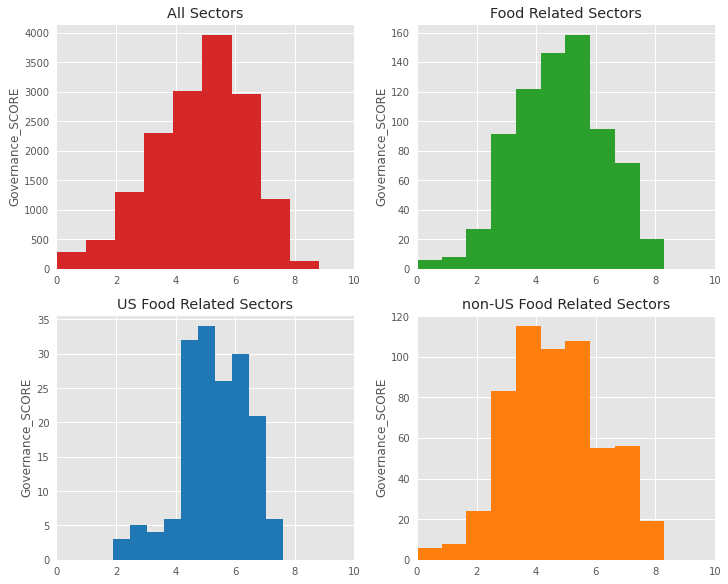

In [128]:
create_histogram_4('Governance_SCORE',ESG_All,'All Sectors',ESG_Food,'Food Related Sectors',ESG_Food_USA,'US Food Related Sectors',ESG_Food_OTH,'non-US Food Related Sectors')

ask the questions 

# Line Graphs Comparisons for Food related Sectors

In [129]:
def create_line_charts_4(t_1,grp_1,t_2,grp_2,t_3,grp_3,t_4,grp_4):
    with plt.style.context(("seaborn","ggplot")):
        fig = plt.figure(constrained_layout=True, figsize=(10,8))
        specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) ## Declaring 2x2 figure.

        ax1 = fig.add_subplot(specs[0, 0]) ## First Row First Column
        ax2 = fig.add_subplot(specs[0, 1]) ## First Row Second Column
        ax3 = fig.add_subplot(specs[1, 0]) ## Second Row First Column
        ax4 = fig.add_subplot(specs[1, 1]) ## Second Row Second Colums

        ## First Graph - Line Graph
        AVG_GRP_1 = grp_1.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_1 = AVG_GRP_1.add_suffix('_Score').reset_index()
        AVG_GRP_1_sorted = AVG_GRP_1.sort_values('Rating_list', ascending=False)
        AVG_GRP_1_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', title = t_1, linewidth=1, ax=ax1)
        AVG_GRP_1_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax1)
        AVG_GRP_1_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax1)
        AVG_GRP_1_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax1)

        ## Second Graph - Line Graph
        AVG_GRP_2 = grp_2.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_2 = AVG_GRP_2.add_suffix('_Score').reset_index()
        AVG_GRP_2_sorted = AVG_GRP_2.sort_values('Rating_list', ascending=False)
        AVG_GRP_2_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', title = t_2, linewidth=1, ax=ax2)
        AVG_GRP_2_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax2)
        AVG_GRP_2_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax2)
        AVG_GRP_2_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax2)

        ## Third Graph - Line Graph
        AVG_GRP_3 = grp_3.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_3 = AVG_GRP_3.add_suffix('_Score').reset_index()
        AVG_GRP_3_sorted = AVG_GRP_3.sort_values('Rating_list', ascending=False)
        AVG_GRP_3_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', title = t_3, linewidth=1, ax=ax3)
        AVG_GRP_3_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax3)
        AVG_GRP_3_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax3)
        AVG_GRP_3_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax3)

        ## Fourth Graph - Line Graph
        AVG_GRP_4 = grp_4.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_4 = AVG_GRP_4.add_suffix('_Score').reset_index()
        AVG_GRP_4_sorted = AVG_GRP_4.sort_values('Rating_list', ascending=False)
        AVG_GRP_4_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', title = t_4, linewidth=1, ax=ax4)
        AVG_GRP_4_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax4)
        AVG_GRP_4_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax4)
        AVG_GRP_4_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax4)
        
        plt.close(fig)
        return fig

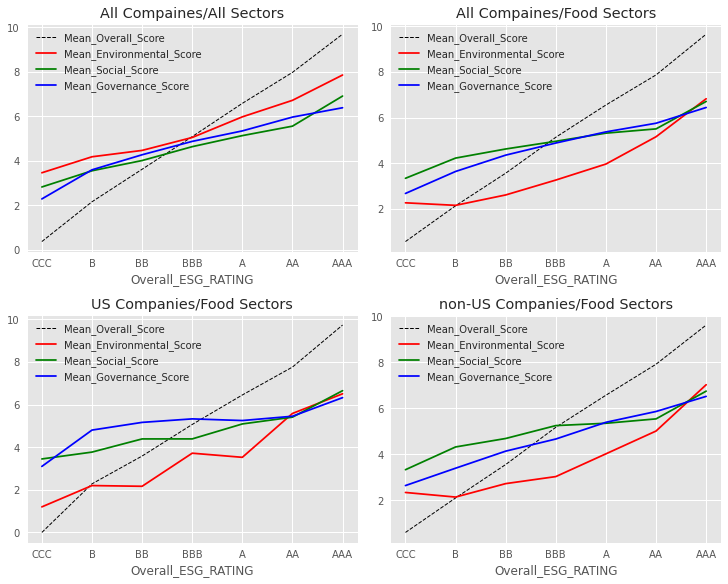

In [130]:
create_line_charts_4('All Compaines/All Sectors',ESG_All,'All Compaines/Food Sectors',ESG_Food,'US Companies/Food Sectors', ESG_Food_USA,'non-US Companies/Food Sectors', ESG_Food_OTH)

In [131]:
ESG_Food_sorted = ESG_Food.sort_values('Rating_list', ascending=True)

#ESG_All.info()
#ESG_Food.info()
#ESG_Food_USA.info()
#ESG_Food_OTH.info()


# Predictive Modeling
## Section 1 - Test for best model to predict Overall ESG Rating using Environmental, Social, and Governance scores.
## Section 2 - Test for best model to predict Overall ESG Rating using Environmental, Social, and Governance scores for companies in one of the food sectors.

In [132]:
ESG_ML = ESG_CC[['Rating_list','Overall_ESG_RATING','Overall_ESG_SCORE','Environmental_SCORE','Social_SCORE', 'Governance_SCORE']]
ESG_ML.columns = ['Rating_list','Rating', 'Overall_ESG', 'Environmental', 'Social', 'Governance']
ESG_ML = ESG_ML.sort_values('Rating_list', ascending=True)
print(ESG_ML.head(2))

     Rating_list Rating  Overall_ESG  Environmental  Social  Governance
9642           1    AAA         10.0            9.9     6.3         5.0
8534           1    AAA         10.0            8.9     7.3         8.0


### Section 1 - All companies / All Sectors

**Test models to see which is the best predictor using all three scores (Environmental, Social and Governance) to predict Rating**

LR: 0.446184 (0.016778)
LDA: 0.460567 (0.011676)
KNN: 0.584658 (0.013150)
CART: 0.685260 (0.014280)
NB: 0.451220 (0.013318)
SVM: 0.499559 (0.009688)


Text(0.5, 1.0, 'Algorithm Comparison')

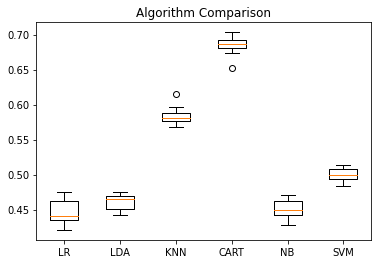

In [133]:
# Split-out validation dataset
array = ESG_ML.values
X = array[:,3:]
y = array[:,1]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=24, shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')

In [134]:
# Make predictions on validation dataset
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.6829658037711729
[[485  62   8  13  26  64   2]
 [ 64 396  22   4   8  24   0]
 [  9  14  96   0   1   2   0]
 [ 14   2   0 242  85  42  29]
 [ 33   7   0  83 384  70  11]
 [ 78  35   1  34  86 433   0]
 [  0   0   0  27  24   8 101]]
              precision    recall  f1-score   support

           A       0.71      0.73      0.72       660
          AA       0.77      0.76      0.77       518
         AAA       0.76      0.79      0.77       122
           B       0.60      0.58      0.59       414
          BB       0.63      0.65      0.64       588
         BBB       0.67      0.65      0.66       667
         CCC       0.71      0.63      0.67       160

    accuracy                           0.68      3129
   macro avg       0.69      0.69      0.69      3129
weighted avg       0.68      0.68      0.68      3129



### Section 2 - Predictibility for companies in food related sectors

**Test models to see which is the best predictor using all three scores (Environmental, Social and Governance) to predict Rating in companies related to the food sector**

In [135]:
ESG_Food_ML = ESG_Food[['Rating_list','Overall_ESG_RATING','Overall_ESG_SCORE','Environmental_SCORE','Social_SCORE', 'Governance_SCORE']]
ESG_Food_ML.columns = ['Rating_list','Rating', 'Overall_ESG', 'Environmental', 'Social', 'Governance']
ESG_FOOD_ML = ESG_Food_ML.sort_values('Rating_list', ascending=True)
print(ESG_Food_ML.head(2))

     Rating_list Rating  Overall_ESG  Environmental  Social  Governance
2180           1    AAA         10.0            6.0     5.0         7.1
6927           1    AAA         10.0            7.8     8.5         6.9


LR: 0.461638 (0.055736)
LDA: 0.609096 (0.047246)
KNN: 0.617429 (0.053858)
CART: 0.634237 (0.033892)
NB: 0.526893 (0.042670)
SVM: 0.639322 (0.052414)


Text(0.5, 1.0, 'Algorithm Comparison')

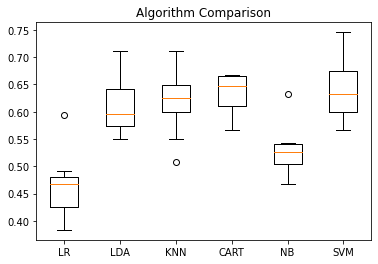

In [136]:
# Split-out validation dataset
array = ESG_Food_ML.values
X = array[:,3:]
y = array[:,1]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=24, shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')

In [137]:
# Make predictions on validation dataset
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.5838926174496645
[[14  5  0  0  1  9  0]
 [ 4 26  1  0  0  0  0]
 [ 0  1  3  0  0  0  0]
 [ 1  0  0 14  8  2  6]
 [ 0  0  0  5 12  5  0]
 [ 2  2  0  1  6 17  1]
 [ 0  0  0  2  0  0  1]]
              precision    recall  f1-score   support

           A       0.67      0.48      0.56        29
          AA       0.76      0.84      0.80        31
         AAA       0.75      0.75      0.75         4
           B       0.64      0.45      0.53        31
          BB       0.44      0.55      0.49        22
         BBB       0.52      0.59      0.55        29
         CCC       0.12      0.33      0.18         3

    accuracy                           0.58       149
   macro avg       0.56      0.57      0.55       149
weighted avg       0.61      0.58      0.59       149

